# GDVSDM

## Initialise GDVSDM

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import sys
import gdal
import pandas as pd
import numpy as np
import xarray as xr
import datacube
from datacube.utils.cog import write_cog
from gdal import DEMProcessing
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('./scripts')
import gdvsdm

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Prepare shapefiles and rasters

### Set shapefile paths

In [2]:
# set shapefile path and file location
#occur_shp_path = r'./data_rf/bradypus/bradypus_p_webmerc.shp'
occur_shp_path = r'./data_testing/presence_points/presence_points.shp'

# example shapefile mask
mask_shp_path = './data_rf/bradypus/sa_polymask_diss_webmerc.shp'

# combine (only for validate)
shp_path_list = [occur_shp_path,  mask_shp_path]

### Set raster paths

In [3]:
# todo
# in arcgis, on prompt, let them select raster layers cont and cat
# we then bring in here as lists of file paths

study_area = 'rio_yandi'
path = r'./data_testing/lidar/{0}'.format(study_area)

rast_cont_list = []
for file in os.listdir(path):
    if file.endswith('.tif'):
        rast_cont_list.append(os.path.join(path, file))

# example categorical rasts
rast_cate_list = []

# example combine
rast_path_list = rast_cont_list + rast_cate_list

In [4]:
rast_path_list

['./data_testing/lidar/rio_yandi/eastness_albers.tif',
 './data_testing/lidar/rio_yandi/slope_deg_albers.tif',
 './data_testing/lidar/rio_yandi/dissection_albers.tif',
 './data_testing/lidar/rio_yandi/yandi_dec_2015_10m_chm_clip_albers.tif',
 './data_testing/lidar/rio_yandi/dem_filled_albers.tif',
 './data_testing/lidar/rio_yandi/solar_rad_albers.tif',
 './data_testing/lidar/rio_yandi/twi_albers.tif',
 './data_testing/lidar/rio_yandi/northness_albers.tif',
 './data_testing/lidar/rio_yandi/tpi_albers.tif',
 './data_testing/lidar/rio_yandi/curvature_albers.tif',
 './data_testing/lidar/rio_yandi/tri_albers.tif']

In [ ]:
rast_cont_list

In [5]:
rast_path_list.remove('./data_testing/lidar/rio_yandi/yandi_dec_2015_10m_chm_clip_albers.tif')
rast_cont_list.remove('./data_testing/lidar/rio_yandi/yandi_dec_2015_10m_chm_clip_albers.tif')

### Validate input layers

In [6]:
# run selected layers through validator, throw error if errors found
gdvsdm.validate_input_data(shp_path_list, rast_path_list)

Comparing shapefile and raster spatial information to check for inconsistencies.
> Extracting shapefile spatial information.
> Extracting raster spatial information.
> Inconsistent coordinate systems between layers. Could cause errors.
> Inconsistent NoData values between layers. Could cause errors.


## Prepare species presence point locations

### Read occurrence shapefile

In [7]:
# extract point x and y from shapefile as numpy array
df_presence = gdvsdm.read_coordinates_shp(occur_shp_path)

# display result
#print(df_presence)

Reading species point locations from shapefile.
> Species point presence observations loaded successfully.


### Read mask shapefile

In [8]:
# load mask polygon, dissolve it, output multipolygon geometry
mask_geom = gdvsdm.read_mask_shp(mask_shp_path)

# display result
#print(mask_geom)

Reading mask polygon(s) from shapefile.
> Compiling geometry and dissolving polygons.
> Mask polygons loaded and dissolved successfully.


## Load rasters

### Convert to dataset

In [9]:
# convert rasters to xarray dataset
ds = gdvsdm.rasters_to_dataset(rast_path_list)

# display result
#print(ds)

Converting rasters to an xarray dataset.
> Converted raster to xarray data array: eastness_albers
> Converted raster to xarray data array: slope_deg_albers
> Converted raster to xarray data array: dissection_albers
> Converted raster to xarray data array: dem_filled_albers
> Converted raster to xarray data array: solar_rad_albers
> Converted raster to xarray data array: twi_albers
> Converted raster to xarray data array: northness_albers
> Converted raster to xarray data array: tpi_albers
> Converted raster to xarray data array: curvature_albers
> Converted raster to xarray data array: tri_albers
> Rasters converted to dataset successfully.



## Prepare species psuedo-absence point locations

### Generate psuedo-absence coordinates

In [10]:
# generate absences using shapefile mask and occurrence coords
#df_absence = gdvsdm.generate_absences_from_shp(mask_shp_path=mask_shp_path, num_abse=500, 
                                               #occur_shp_path=occur_shp_path, buff_m=50000)

# generate absences using dataset pixels and occurrence coords
df_absence = gdvsdm.generate_absences_from_dataset(ds=ds, num_abse=1000, occur_shp_path=occur_shp_path,
                                                   buff_m=100, res_factor=3, nodata_value=-9999)

# display result
#print(df_absence)

Generating 1000 randomised psuedo-absence locations.
> Generating buffer areas from occurrence points.
Generating proximity buffers around species point locations.
> Proximity buffers loaded and dissolved successfully.
> Randomising absence points within mask area.
Extracting cell resolution from dataset.
> Resolution extracted successfully from dataset.
> Generated pseudo-absence points successfully.


### Extract variable values at observed point locations

In [11]:
# extract values from dataset variables at each presence point coord
df_presence_data = gdvsdm.extract_dataset_values(ds=ds, coords=df_presence, res_factor=3)

# display result
#print(df_presence_data)

Extracting xarray dataset values to x and y coordinates.
Extracting cell resolution from dataset.
> Resolution extracted successfully from dataset.
> Extracted xarray dataset values successfully.



In [12]:
# remove all records containing nodata values
df_presence_data = gdvsdm.remove_nodata_records(df_presence_data)

# display result
#print(df_presence_data)

Removing records containing NoData (-9999) values.
> Removed 3120 records containing NoData values successfully.


### Extract variable values at pseudoabsence point locations

In [13]:
# extract values from dataset variables at each presence point coord
df_absence_data = gdvsdm.extract_dataset_values(ds=ds, coords=df_absence, res_factor=3)

# display result
#print(df_absence_data)

Extracting xarray dataset values to x and y coordinates.
Extracting cell resolution from dataset.
> Resolution extracted successfully from dataset.
> Extracted xarray dataset values successfully.



In [14]:
# remove all records containing nodata values
df_absence_data = gdvsdm.remove_nodata_records(df_absence_data)

# display result
#print(df_absence_data)

Removing records containing NoData (-9999) values.
> Removed 0 records containing NoData values successfully.


### Equalise records

In [15]:
# equalise absence to match number of presence
#df_absence_data = gdvsdm.equalise_absence_records(df_presence_data, df_absence_data)

# display result
#print(df_absence_data)

### Combine presence and absence records

In [16]:
# take pres and abse records and combine, add new pres/abse column
df_pres_abse_data = gdvsdm.combine_presence_absence_records(df_presence_data, df_absence_data)

# display result
#print(df_pres_abse_data)

Combining presence and pseudo-absence point locations.
> Combined presence and absence records: total of 1827 records.


## Investigate variable correlation and variance inflation

### Generate Pearson's correlation matrix

> Presenting correlation matrix.


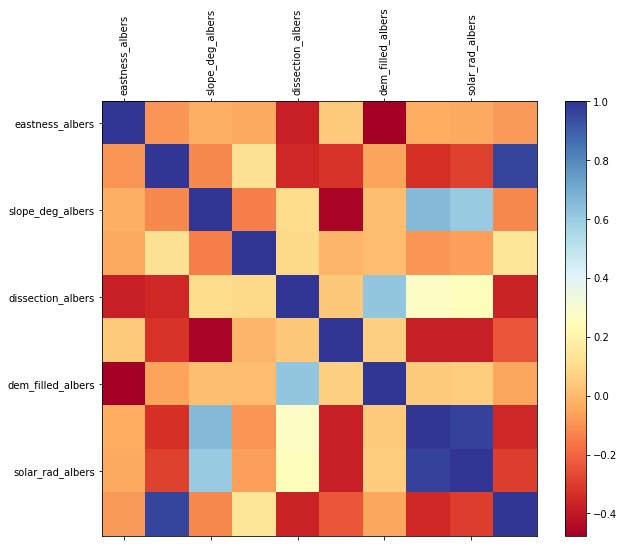



> Presenting correlation pairs.
eastness_albers  eastness_albers      1.000000
                 slope_deg_albers    -0.088112
                 dissection_albers   -0.023872
                 dem_filled_albers   -0.039343
                 solar_rad_albers    -0.378090
                                        ...   
tri_albers       twi_albers          -0.238697
                 northness_albers    -0.047570
                 tpi_albers          -0.355536
                 curvature_albers    -0.294047
                 tri_albers           1.000000
Length: 100, dtype: float64


In [17]:
# generate the matrix
# rule of thumb: < 0.6 = weak collinearity, 0.6-0.8 = moderate, >= 0.8 = strong
gdvsdm.generate_correlation_matrix(df_pres_abse_data, rast_cate_list, show_fig=True)

### Generate Variance Inflation Factor (VIF) Score

In [18]:
# generate the matrix
# rule of thumb: 1 = No multicolinearity, 1-5 = moderate, > 5 = high, > 10 = Remove from model
gdvsdm.generate_vif_scores(df_pres_abse_data, rast_cate_list)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            Variable  VIF Score
3  dem_filled_albers      1.092
0    eastness_albers      1.373
5         twi_albers      1.857
6   northness_albers      1.969
2  dissection_albers      2.193
4   solar_rad_albers      2.269
9         tri_albers     16.971
1   slope_deg_albers     17.605
8   curvature_albers     19.858
7         tpi_albers     24.011
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



## Perform Species Distribution Modelling 

### Create estimator

In [19]:
# create a random forest estimator using default sklearn parameters
estimator = gdvsdm.create_estimator(estimator_type='rf', n_estimators=100)

Creating species distribution model estimator.
> Setting up estimator for Random Forest.
> Estimator created successfully.


### Generate SDM

Beginning species distribution modelling (SDM) process.
> Generating SDM replicate: 1 of 5.
> Generating SDM replicate: 2 of 5.
> Generating SDM replicate: 3 of 5.
> Generating SDM replicate: 4 of 5.
> Generating SDM replicate: 5 of 5.
> SDM processing completed. Getting outputs in order.
> User requested accuracy results. Preparing accuracy information.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
            Variable  Mean Importance Score
3  dem_filled_albers               0.195574
9         tri_albers               0.123831
8   curvature_albers               0.102002
2  dissection_albers               0.096943
1   slope_deg_albers               0.091272
7         tpi_albers               0.089751
5         twi_albers               0.086900
4   solar_rad_albers               0.073872
6   northness_albers               0.070533
0    eastness_albers               0.069323
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - - - - 

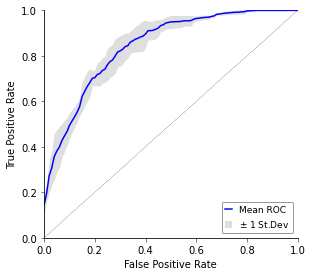

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training Out-Of-Bag (OOB) Accuracy:		1.0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - Probabilities Accuracy Metrics  - - - - - - - - - - - - 
Area Under the ROC Curve (AUC).
Terrible = 0.5 | Moderate = 0.75 | Perfect = 1.0
AUC: 0.84

Area Under the Precision Recall Curve (PR Score).
Terrible = 0.0 | Perfect = 1.0.
PR Score: 0.803

Brier Loss Score.
Terrible: 1.0 | Perfect: 0.0 (lower score is better).
Brier Loss Score: 0.163

Log-Loss Score (stricter than Brier Loss Score).
Perfect: 0.0 (lower score is better).
Log-Loss Score: 0.486

Point-biserial Correlation Coefficient (R-value).
Perfect + relationship = 1 | Perfect - relationship = -1 | No relationship = 0. 
R-value: 0.587
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - Classification Accuracy Metrics - - - - - - - - - - - - 
Proportion of presence records: 0.003
Proporti

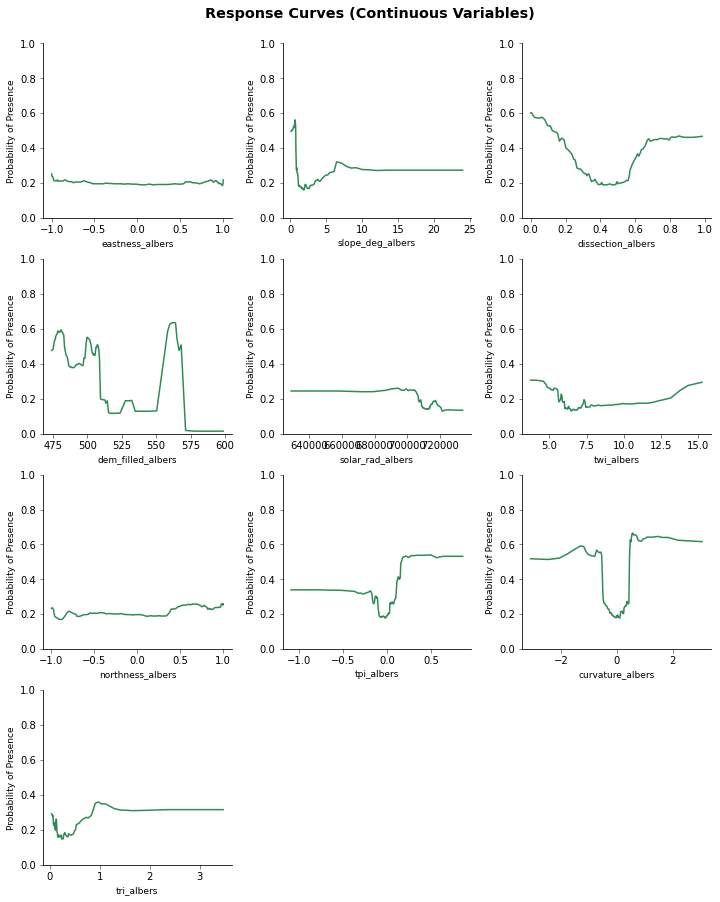

In [20]:
%autoreload
# generate SDM with 5 replicates and 10% training-testing split
ds_sdm = gdvsdm.generate_sdm(ds, df_pres_abse_data, estimator, rast_cont_list, rast_cate_list, replicates=5, 
                             test_ratio=0.1, equalise_test_set=True, calc_accuracy_stats=True)

### Display SDM result

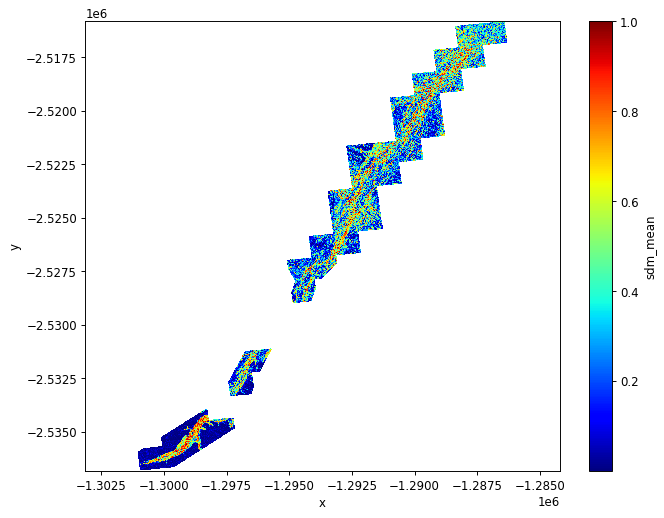

In [21]:
# set the sdm variable to display (i.e. sdm_mean, sdm_stdv, sdm_cvar)
metric_name = 'sdm_mean'

# create fig
fig = plt.figure(figsize=(9, 7), dpi=85)

# plot this on map
ds_sdm[metric_name].plot(robust=False, cmap='jet')

In [22]:
# add crs
from datacube.utils.geometry import assign_crs
ds_sdm = assign_crs(ds_sdm, crs='EPSG:3577')

# export dem tif
num_pa = '1k'
is_chm = 'wo'
fn = '{0}_sdm_{1}_{2}_chm.tif'.format(study_area, num_pa, is_chm)

# write sdm mean
write_cog(geo_im=ds_sdm['sdm_mean'],
          fname=fn,
          crs='EPSG:3577',
          nodata=-9999,
          overwrite=True)

PosixPath('rio_yandi_sdm_1k_wo_chm.tif')

## Temporary dem retriever

### Set up a dask cluster

In [ ]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

In [ ]:
# open up a datacube connection
dc = datacube.Datacube(app='gdvsdm')

## Study area and data setup

### Set study area

In [ ]:
# set nw lat, lon and se lat, lon (y, x) dictionary of areas for gdv project
loc_dict = {
    'sa_1':     (-22.234399915999973, 116.71406189400011, -22.528879000999950, 117.43794151600002),
    'sa_2':     (-21.983755495999958, 117.55460603200004, -22.354478219999976, 118.28166962300008),
    'sa_3':     (-22.697654046999958, 118.96531333300004, -22.931679326999983, 119.33028165500002),
    'sa_4':     (-23.202754411999933, 119.78069440200011, -23.379147521999982, 119.91568500400001),
    'sa_5':     (-22.283108590999973, 119.10020216600003, -22.357883308999931, 119.53679360300009),
    'sa_6':     (-22.288172512999950, 119.73868493300006, -22.802725473999942, 120.13685110000006),
    'sa_7':     (-21.186909955999965, 118.96938286200009, -21.273462510999934, 119.08414957200011),
    'sa_8':     (-21.295006280999928, 119.67533818800007, -21.438759023999978, 119.74417034100009)
}

In [ ]:
# select location from dict
study_area = 'sa_8'

# combine centroid with buffer to form study boundary
lat_extent = (loc_dict[study_area][0], loc_dict[study_area][2])
lon_extent = (loc_dict[study_area][1], loc_dict[study_area][3])

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load SRTM Digital Elevation Model (Resampled to 30m)

In [ ]:
# create query from above and expected info
query = {
    'x': lon_extent,
    'y': lat_extent,
    'measurements': ['dem'],
    'output_crs': 'EPSG:3577',
    'resolution': (30, 30),
    'group_by': 'solar_day',
}


# load srtm dem dataset # multi_scale_topographic_position
ds_dem = dc.load(product='ga_srtm_dem1sv1_0', **query)

# drop time dimension and squeeze out time coordinate
ds_dem = ds_dem.drop('time', errors='ignore')
ds_dem = ds_dem.squeeze('time', drop=True)

# display dataset
#print(ds_dem)

# plot
ds_dem['dem'].plot(robust=True)

In [ ]:
# export dem tif
write_cog(geo_im=ds_dem['dem'].astype('int16'),
          fname='{0}_srtm_dem_30m.tif'.format(study_area),
          crs='EPSG:3577',
          nodata=-9999,
          overwrite=True)